# Time series forecasting

This tutorial uses safeds on **US inflation rates data** to predict future inflation with a recurrent neural network. The **US inflation rates data** is a time series. A time series, is a series with frequently measured values. This time series measures the inflation of the US every Month from January 1947 until June 2023.


1. Load your data into a `Table`. The data is available under `docs/tutorials/data/US_Inflation_rates.csv`:


In [1]:
from safeds.data.tabular.containers import Table

inflation = Table.from_csv_file("data/US_Inflation_rates.csv")
# For visualisation purposes we only print out the first 15 rows.
inflation.slice_rows(0,15)

date,value
str,f64
"""1947-01-01""",21.48
"""1947-02-01""",21.62
"""1947-03-01""",22.0
"""1947-04-01""",22.0
"""1947-05-01""",21.95
…,…
"""1947-11-01""",23.06
"""1947-12-01""",23.41
"""1948-01-01""",23.68


This dataset contains two columns: date and value. The date column is right now still a string type with a format like this: "Year-Month-Day". We can convert it into a temporal type column like this:

In [2]:
inflation = inflation.replace_column("date", [inflation.get_column("date").temporal.from_string("%Y-%m-%d")])
inflation.slice_rows(0,15)

date,value
date,f64
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.0
1947-04-01,22.0
1947-05-01,21.95
…,…
1947-11-01,23.06
1947-12-01,23.41
1948-01-01,23.68


As we can see the date column is no longer in quotes.

2. In the second step we prepare the data, to train our neural network. For that we need to normalize our data, because neural networks work better on values between 0 and 1. After that, we split the data into a training and test set.


In [3]:
from safeds.data.tabular.transformation import RangeScaler

scaler = RangeScaler()
trained_scaler, inflation = scaler.fit_and_transform(inflation)
train_set, test_set = inflation.split_rows(percentage_in_first=0.8, shuffle=False)

3. To finish our data preparation we mark the datasets as time series, so they can be used in such context for the neural networks:

In [4]:
train_time_series = train_set.to_time_series_dataset(target_name="value", time_name="date", window_size=12, forecast_horizon=1)
test_time_series = test_set.to_time_series_dataset(target_name="value", time_name="date", window_size=12, forecast_horizon=1)


If we want to use a neural network to predict what the inflation will be next month, we have to provide it with a relevant chunk of past data that it can learn from. Think of it like looking at a series of snapshots from the past to guess what's going to happen next.

Instead of feeding the entire history of inflation data to the neural network all at once, which could be overwhelming and not very helpful, we divide the historical data into smaller, more manageable parts. This technique is known as "windowing."

A "window" in this context is just a set portion of consecutive data points from the time series. By giving the neural network these windows, it can start to understand how the numbers in the past relate to future values.

In our case, we want to look at the last 8 months of inflation data to make a guess about the inflation for the upcoming month. So, we choose a window size of 8. This window will slide across our time series data, providing the neural network with different 8-month segments to learn from.

Finally, we tell our neural network that our forecast horizon is 1, meaning that we're interested in predicting the value for just one step ahead—the next month's inflation rate.

So, simply put, we set up our neural network to take in 8-month chunks of inflation data to help it make a forecast about the inflation rate for the next month.



In [6]:
from safeds.ml.nn import NeuralNetworkRegressor

from safeds.ml.nn.converters import (
    InputConversionTimeSeries,
)
from safeds.ml.nn.layers import (
    ForwardLayer,
    LSTMLayer,
)

neural_network = NeuralNetworkRegressor(
    InputConversionTimeSeries(continuous=False),
    [ForwardLayer(input_size=12, output_size=256), LSTMLayer(input_size=256, output_size=1)],
)
fitted_neural_network = neural_network.fit(train_time_series, epoch_size=5)

C:\Users\ettel\PycharmProjects\Library\venv\Lib\site-packages\torch\utils\_device.py:78: UserWarning: Using a target size (torch.Size([1, 1, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


5. Now that we defined and trained our model, we can start making predictions.

In [7]:
prediction = fitted_neural_network.predict(
    test_time_series
)
prediction = prediction.to_table()
# For visualisation purposes we only print out the first 15 rows.
prediction.slice_rows(start=0, length=15)

date,value
date,f64
2009-04-01,0.605816
2009-05-01,0.60486
2009-06-01,0.603875
2009-07-01,0.60183
2009-08-01,0.599713
…,…
2010-02-01,0.601924
2010-03-01,0.603035
2010-04-01,0.603165


6. Now we only need to inverse our predictions and we can start visualizing them:


In [8]:
prediction = trained_scaler.inverse_transform(prediction)
test_set = trained_scaler.inverse_transform(test_set)


In [10]:
preds_with_test = prediction.add_columns([test_set.slice_rows(13).rename_column("value","test_value").get_column("test_value")])

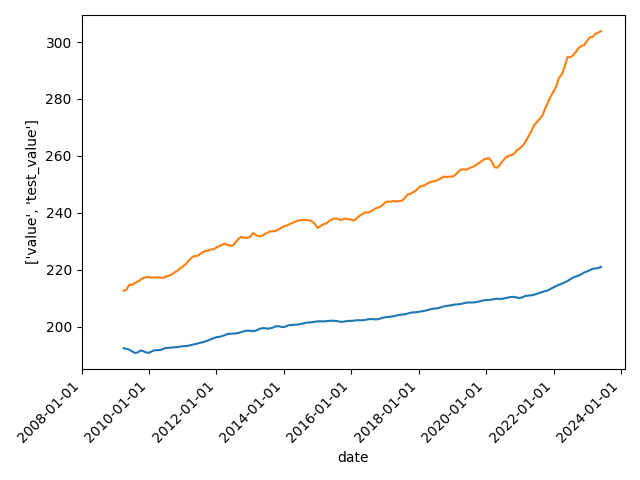

In [13]:
preds_with_test.plot.line_plot("date", ["value", "test_value"])